In [1]:
import numpy as np
from matplotlib_scalebar.scalebar import ScaleBar
import math
from scipy.spatial.distance import pdist, squareform
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import hyperspy.api as hs
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

In [9]:
## Useful for increasing image quality
import matplotlib as mpl
mpl.rc("figure", dpi=100)

In [2]:
%matplotlib inline

In [3]:
# Load data
s = hs.load(r'D:/PostDoc CEMES/Manip/BePOLAR/20221215 - JWF4 110 +2.5mm/STO bulk - LSMO/30-31/Cophus corrected cropped.dm3')
X = np.loadtxt(r'D:/PostDoc CEMES/Manip/BePOLAR/20221215 - JWF4 110 +2.5mm/STO bulk - LSMO/30-31/atom A positions.txt')

In [11]:
def distance_plot(k, Calibration, color, thresh_max, thresh_min):
    """
    This function will display all the atoms in a HRSTEM image and connect them with colored lines.
    
    Parameters
    ----------
    k : int, number of neighbors, the first neigbor is the atom itself, so put 2 to have at least one connexion to a nearest
        neighbor.
    Calibration : float, in nanometer. For your image calibration.
    color : chose a color out of matplotlib.colors.ListedColormap
    thresh_max: float, maximum distance threshold that will be displayed on the image (in pm)
    thresh_min: float, minimum distance threshold that will be displayed on the image (in pm)
    
    Examples
    ----------
    distance_plot(k=5, Calibration=0.010863, color='magma',thresh_max=417, thresh_min=350)
    
    """
    
    # Colormap
    cmap=plt.get_cmap(color)

    # Number of atoms in the data
    N=len(X)

    # Calculate pairwise Euclidean distances
    distmat = squareform(pdist(X, 'euclidean'))

    # Function for calculating distance between two points
    def dist(x1, y1, x2, y2):
        return math.sqrt((x2-x1)**2 + (y2-y1)**2)

    # Select the kNN for each datapoint
    neighbors = np.sort(np.argsort(distmat, axis=1)[:, 0:k])

    # Get edge coordinates and distance
    coordinates = np.zeros((N, k, 2, 2))
    distance = []

    for i in np.arange(N):
        for j in np.arange(k):
            coordinates[i, j, :, 0] = np.array([X[i,:][0], X[neighbors[i, j], :][0]])
            coordinates[i, j, :, 1] = np.array([X[i,:][1], X[neighbors[i, j], :][1]])
            distance.append(dist(coordinates[i][j][0][0], coordinates[i][j][0][1], coordinates[i][j][1][0], coordinates[i][j][1][1]))

    # Threshold to keep only coordinates below a certain value
    coordinates = coordinates.tolist()
    new_coordinates = []

    fig, ax = plt.subplots(1, 1)

    for i in np.arange(len(coordinates)):
        for j in np.arange(k):
            if dist(coordinates[i][j][0][0], coordinates[i][j][0][1], coordinates[i][j][1][0], coordinates[i][j][1][1]) > thresh_max/(Calibration*1000):
                new_coordinates.append(coordinates[i][j])
                distance.remove(dist(coordinates[i][j][0][0], coordinates[i][j][0][1], coordinates[i][j][1][0], coordinates[i][j][1][1]))
            if dist(coordinates[i][j][0][0], coordinates[i][j][0][1], coordinates[i][j][1][0], coordinates[i][j][1][1]) < thresh_min/(Calibration*1000):
                new_coordinates.append(coordinates[i][j])
                distance.remove(dist(coordinates[i][j][0][0], coordinates[i][j][0][1], coordinates[i][j][1][0], coordinates[i][j][1][1]))

    distance = [i*Calibration*1000 for i in distance]
    new_coordinates = np.round_(new_coordinates, decimals=8)
    new_coordinates = new_coordinates.tolist()
    coordinates = np.asarray(coordinates)
    
    #Plotting
    
    norm = Normalize(vmin=thresh_min, vmax=thresh_max)
    line_colors = cmap(norm(distance))
    coco = coordinates.reshape((N*k, 2, 2)).tolist()
    coco = np.round_(coco, decimals=8)
    coco = coco.tolist()
    result = np.array([position for position in coco if position not in new_coordinates])
    
    lines = LineCollection(result, linewidth=3, colors=line_colors)
    
    ax.scatter(X[:, 0], X[:, 1], c='black', s=5)
    
    ax.add_collection(lines)
    
    mappable = ScalarMappable(cmap=cmap, norm=norm)
    cb = fig.colorbar(mappable)
    cb.set_label('Distance (pm)')
    lines.set_clim(vmin=thresh_min, vmax=thresh_max)
    scalebar = ScaleBar(Calibration*1000, 'pm', location=4)
    plt.gca().add_artist(scalebar)
    
    plt.imshow(s, cmap="gray")
    plt.sci(lines)
    plt.show()

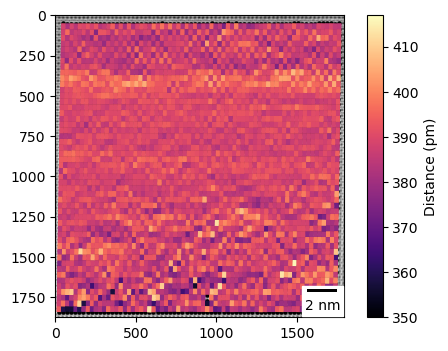

In [12]:
#Use this function to plot the result

distance_plot(k=5, Calibration=0.010863, color='magma',thresh_max=417, thresh_min=350)